1. Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

----

In [249]:
from sklearn import datasets

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

Воспользуемся наработками прошлого занятия и заимствуем реализацию дерева:

In [3]:
class Node:
    '''
    Узел решающего дерева, храняющий определитель признака и порогового значения, а также
    направления на следующие узлы.
    '''
    def __init__(self, index, thershold, true_branch, false_branch):
        self.index = index  # индекс признака
        self.thershold = thershold
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    '''
    Узлы, в которых происходит выдача предсказания и дальше дерево не строится
    '''
    def __init__(self, data, labels, prediction_type):
        self.data = np.array(data)
        self.labels = np.array(labels)
        self.prediction_type = prediction_type
        self.prediction = self.predict()
        
    def predict(self):
        if self.prediction_type == 'classification':
            classes, labels_cnt = np.unique(self.labels, return_counts=True)
            prediction = classes[labels_cnt == labels_cnt.max()][0]
        elif self.prediction_type == 'regression':
            prediction = self.labels.mean()
        return prediction

class DecisionTree:
    '''
    Классификатор или регрессор, построенный на алгоритме решающего дерева.
    
    
    Parameters:
    -----------
    predict_type: str {"classification", "regression"}
        Тип решаемой задачи алгоритмом. По умолчанию "classification"
    max_depth: int
        Максимальная глубина дерева.
    min_leaf: int
        Минимальное число объектов на одном листе дерева.
    criterion: {"gini", "entropy"}
        Критерий разбиения значения в разные узлы для классификации.
        Для задачи регрессии используется оценка дисперсии признаков и атрибут не учитывается.
    max_leafes_number: int
        Максимальное число листьев. В текущей реализации возможны случаи,
        когда количество листьев будет несколько выше указанного значения.
    
    '''
    def __init__(self,
                 predict_type: str='classification',
                 max_depth: int=None,
                 min_leaf: int=1,
                 criterion: str='gini',
                 max_leafes_number: int=None):
        # перечисленные параметры являются параметрами останова, настраиваемыми далее. 1 задание
        self.__predict_type = predict_type
        self.__max_depth = max_depth
        self.__min_leaf = min_leaf
        if predict_type == 'regression':
            criterion = 'variance'
        self.__criterion = criterion
        self.__max_leafes_number = max_leafes_number
        self.__n_leafs = 0
    
    def _gini(self, labels: np.array):
        '''
        Расчет порогового значения в узле(Node) на основании критерия Джини.
        Первая часть 2 задания
        '''        
        labels = np.array(labels)
        classes, size = np.unique(labels, return_counts=True)
        impurity = 1 - ((size / labels.shape)**2).sum()
        return impurity
        
    def _entropy(self, labels: np.array):
        '''
        Расчет порогового значения в узле(Node) на основании энтропии.
        Первая часть 2 задания
        '''
        labels = np.array(labels)
        classes, size = np.unique(labels, return_counts=True)
        p = size / labels.shape
        impurity = - (p * np.log2(p)).sum()
        return impurity

    def _variance(self, labels: np.array):
        '''
        Расчет порогового значения в узле(Node) на основании дисперсии целевой переменной.
        3 задание
        '''
        labels = np.array(labels)
        M_x = labels.mean()
        impurity = ((labels - M_x)**2).mean()
        return impurity
    
    def _quality(self, left_labels, right_labels, criteria_current):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        if self.__criterion == 'gini':
            criteria = self._gini
        elif self.__criterion == 'entropy':
            criteria = self._entropy
        elif self.__criterion == 'variance':
            criteria = self._variance
        return criteria_current - p * criteria(left_labels) - (1 - p) * criteria(right_labels)
    
    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    def _find_best_split(self, data, labels):
        if self.__criterion == 'gini':
            criteria = self._gini
        elif self.__criterion == 'entropy':
            criteria = self._entropy
        elif self.__criterion == 'variance':
            criteria = self._variance
            
        criteria_current = criteria(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                if min(len(true_data), len(false_data)) < self.__min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, criteria_current)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def _build_tree(self, data, labels, depth=0):
        quality, t, index = self._find_best_split(data, labels)

        if quality == 0 or (self.__max_depth is not None and depth >= self.__max_depth)\
        or (self.__max_leafes_number is not None and self.__n_leafs >= self.__max_leafes_number - 1):
            self.__n_leafs += 1
            return Leaf(data, labels, self.__predict_type)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
        
        true_branch = self._build_tree(true_data, true_labels, depth + 1)
        false_branch = self._build_tree(false_data, false_labels, depth + 1)

        return Node(index, t, true_branch, false_branch)
    
    def _classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.thershold:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
    
    def fit(self, X, y):
        '''
        Обучает модель.
        
        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        self.__tree = self._build_tree(X, y)
    
    def predict(self, X):
        '''
        Отдает предсказания обученной модели.
        
        Parameters:
        -----------
        X: array like
            Значения признаков
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
#         classes = []
#         for obj in X:
#             prediction = self._classify_object(obj, self.__tree)
#             classes.append(prediction)
#         return classes
        classes = np.array([])
        for obj in X:
            prediction = self._classify_object(obj, self.__tree)
            classes = np.append(classes, prediction)
        return classes
    
    def fit_predict(self, X, y):
        '''
        Обучает модель и отдает ее предсказания.
        
        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        self.fit(X, y)
        return self.predict(X)

In [199]:
class BootstrapAggregation():
    '''
    Алгоритм, основанный на усреднении предсказаний ряда базовых алгоритмов.
    
    Parameters:
    -----------
    algorithm: type
        Тип базового алгоритма, участвующего в bootstrap агрегации.
        Гиперпараметры передаются сразу после указания всех параметров для BootstrapAggregation.
            ВАЖНО: передавать следует сам тип, а не экземпляр алгоритма: например,
            DecisionTreeClassifier вместо DecisionTreeClassifier().
    alg_count: int
        Количество базовых алгоритмов, участвующих в обучении.
    sample_size: int
        Размер перемешанной выборки с возвращением, участвующей в обучении.
    features_in_sample: int
        Количество признаков, участвующие в обучении.
    OOB: bool
        Метка, указывающая, следует ли активировать механизм Out-of-Bag.
        При нем выборка, не участвовавшая в процессе обучения используется для предсказания результатов,
        тем самым убирая необходимость использования кросс-валидации.
    '''
    def __init__(self, algorithm, alg_count=50, sample_size=None, features_in_sample=None, OOB=False, **kwargs):
        if isinstance(algorithm, type):
            self.__algorithm = algorithm
        else:
            raise TypeError('В "algorithm" принимается тип алгоритма, но не экземпляр базовой модели.')
        self.__alg_count = alg_count if alg_count > 1 else 1
        self.__s_size = sample_size
        self.__s_features = features_in_sample
        self.__OOB = OOB
        self.__kw = kwargs
    
    def _get_subsample(self, features_count, features_sample):
        subsample = np.random.choice(np.arange(features_count), replace=False, size=features_sample)
        return subsample
        
    def _get_bootstrap(self, data_size, samle_size):
        bootstrap = np.random.choice(np.arange(data_size), replace=True, size=samle_size)
        return bootstrap
    
    def fit(self, X, y):
        '''
        Обучает модель.
        
        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        self.__models = []
        self.__OOB_predicts = np.empty_like(y).astype('float')
        self.__OOB_predicts[:] = np.nan
        y_ind = np.arange(y.shape[0])
        s_features = self.__s_features
        s_size = self.__s_size
        if s_features is None:
            s_features = int(X.shape[1]**0.5)
        if s_size is None:
            s_size = X.shape[0]
        elif s_size < 1:
            s_size = int(X.shape[0] * s_size)
            
        for i in range(self.__alg_count):
            b_labels = self._get_subsample(X.shape[1], s_features)
            b_rows = self._get_bootstrap(X.shape[0], s_size)
            b_X = X[b_rows][:, b_labels].copy()
            b_y = y[b_rows].copy()
            model = self.__algorithm
            self.__models.append([model(**self.__kw), b_labels])
            self.__models[i][0].fit(b_X, b_y)
            if self.__OOB:
                # TODO: оптимизировать, чтобы предсказания каждого алгоритма производились не по всей X перед отбором наблюдений
                y_pred = self.__models[i][0].predict(X[:, self.__models[i][1]])
                y_pred = np.where(np.isin(y_ind, b_rows), np.nan, y_pred)
                self.__OOB_predicts = np.vstack([self.__OOB_predicts, y_pred.copy()])
        if self.__OOB:
            self.__OOB_predicts = np.nanmean(self.__OOB_predicts.T, axis=1)
        
    def predict_OOB(self):
        '''
        Отдает вероятность принадлежности объекта к классу 1 для не принимающих
        в обучении наблюдений в bootstrap выборке.
        Для каждого базового алгоритма вычисляется принадлежность к классу в self.fit() и в итоге усредняется. 
        
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        return self.__OOB_predicts
    
    def predict_proba(self, X):
        '''
        Отдает вероятность принадлежности объекта к классу 1.
        
        Parameters:
        -----------
        X: array like
            Значения признаков
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        predicts = None
        for model in self.__models:
            if predicts is None:
                predicts = model[0].predict(X[:, model[1]]).reshape(-1, 1)
            else:
                predicts = np.hstack((predicts.copy(), model[0].predict(X[:, model[1]]).reshape(-1, 1)))
        return predicts.mean(axis=1)

    def predict(self, X, prob=0.5):
        '''
        Отдает предсказания обученной модели.
        
        Parameters:
        -----------
        X: array like
            Значения признаков
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        pred = self.predict_proba(X)
        pred = np.where(pred < prob, 0, 1)
        return pred
    
    def fit_predict(self, X, y):
        '''
        Обучает модель и отдает ее предсказания.
        
        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        self.fit(X, y)
        return self.predict(X)

In [79]:
def accuracy_metric(actual, predicted):
    return (np.nan_to_num(actual, nan=np.inf) == np.nan_to_num(predicted, nan=np.inf)).sum() / actual.shape[0]

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [319]:
data, labels = datasets.make_classification(n_samples=1000, n_features=2, n_redundant=0,
                                            random_state=33, n_classes=2, class_sep=1)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.3, random_state = 20)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])


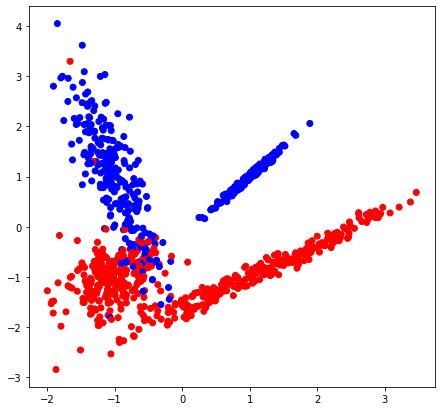

In [320]:
plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = colors)
plt.show()


Создадим случаи обучения при 1, 3, 10, 50, 100, 200 и бонусом на **500** деревьях (причем последние 4 сделаем на основе не созданного класса решающего дерева, а готового решения из `sklearn` для ускорения процесса). При этом в последних трех вариантах воспользуемся фичей Out-of-Bag и оценим метрику `accuracy` на ней, сравним с этой же метрикой на test выборке:

In [321]:
model_1 = BootstrapAggregation(DecisionTree, alg_count=1)
model_3 = BootstrapAggregation(DecisionTree, alg_count=3)
model_10 = BootstrapAggregation(DecisionTree, alg_count=10)
model_50 = BootstrapAggregation(DecisionTreeClassifier, alg_count=50)
model_100 = BootstrapAggregation(DecisionTreeClassifier, alg_count=100, OOB=True)
model_200 = BootstrapAggregation(DecisionTreeClassifier, alg_count=200, OOB=True)
model_500 = BootstrapAggregation(DecisionTreeClassifier, alg_count=500, OOB=True)

models = {1: model_1,
          3: model_3,
          10: model_100,
          50: model_50,
          100: model_100,
          200: model_200,
          500: model_500
         }


Number of trees: 1


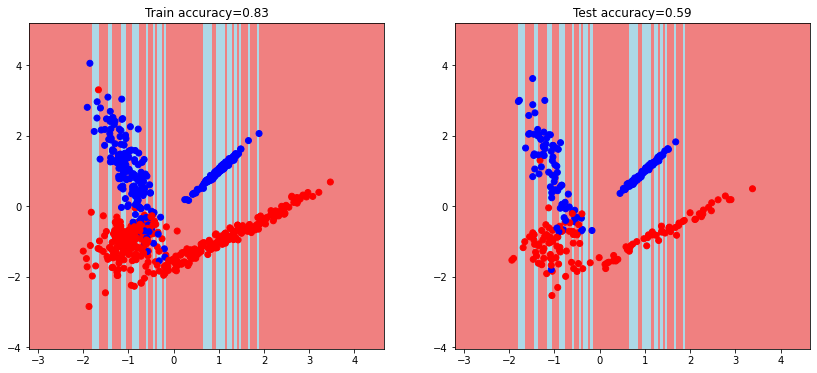

------------------------------------
Number of trees: 3


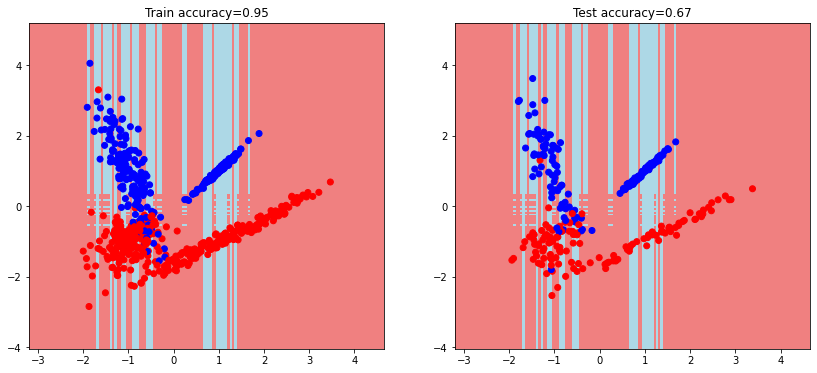

------------------------------------
Number of trees: 10


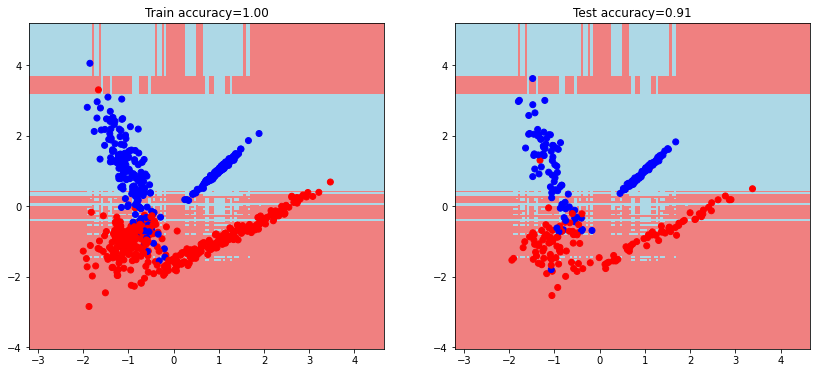

------------------------------------
Number of trees: 50


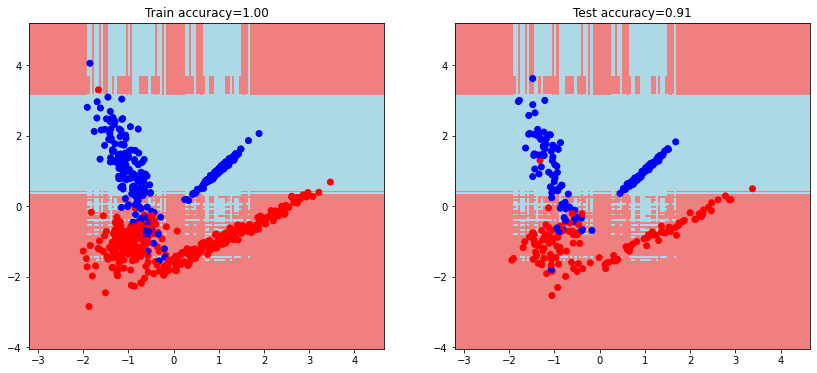

------------------------------------
Number of trees: 100


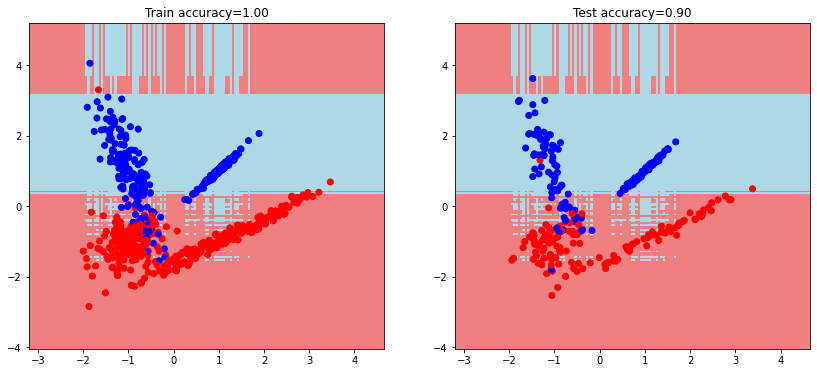

------------------------------------
Number of trees: 200


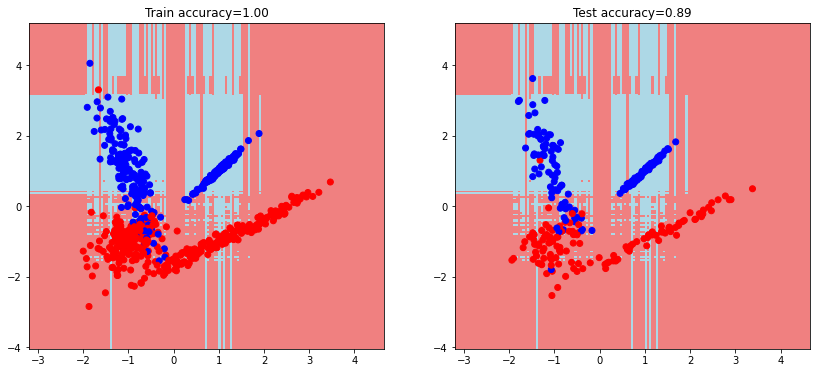

------------------------------------
Number of trees: 500


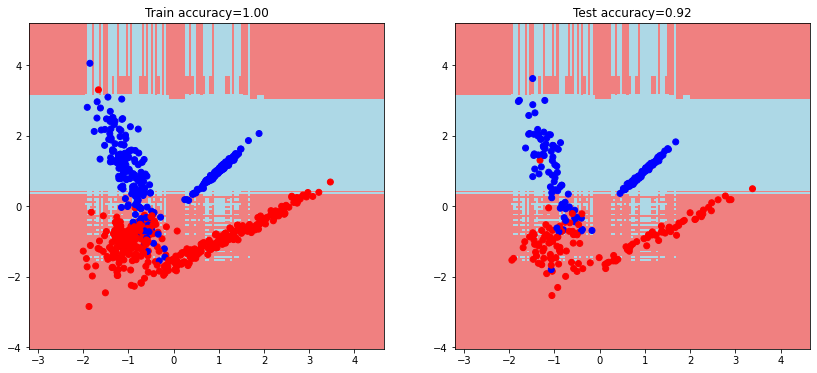

------------------------------------


In [323]:
for trees_cnt, model in models.items():
    pred_train = model.fit_predict(train_data, train_labels)
    pred_test = model.predict(test_data)
    
    train_accuracy = accuracy_metric(pred_train, train_labels)
    test_accuracy = accuracy_metric(pred_test, test_labels)
    
    plt.figure(figsize = (14, 6))

    print('Number of trees:', trees_cnt)
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()
    print('------------------------------------')

Видно, что приблизительно с 10 деревьев начинает проявляться явная подстрояка решений модели под какие-то не слишком явные паттерны в данных, что косвенно уже может говорить об лучшем результате по сравнению с базовым алгоритмом (в данном случае решающим деревом). С увеличением числа алгоритмов паттерны в принимаемых решениях проявляются все более выраженно.

Если до 10 деревьев можно говорить о том, что модель еще не обучилась, то позднее уже сложно сказать, в какой момент количество деревьев становится достаточным для завершения обучения. Все значения метрик с 3 шага лежат приблизительно в одном диапазоне.

----


Теперь сравним предсказания функционала Out-of-Bag (т.к. изначально они возвращают не классы, а вероятность класса **1**, приведем их к соответствующему виду):

In [341]:
print('\t\taccuracy (test):\taccuracy (OOB):')
for trees_cnt, model in models.items():
    if trees_cnt >=100:
        pred_OOB = np.where(model.predict_OOB() < 0.5, 0, 1)
        accur_test = round(accuracy_metric(model.predict(test_data), test_labels), 5)
        accur_OOB = round(accuracy_metric(pred_OOB, train_labels), 5)
        
        print(f'{trees_cnt} trees:\t{accur_test} \t\t\t{accur_OOB}')
        

		accuracy (test):	accuracy (OOB):
100 trees:	0.9 			0.88857
200 trees:	0.89 			0.84143
500 trees:	0.92 			0.87857


Разница в значениях все же есть, но действительно механизм OOB в какой-то степени можно использовать вместо достаточно долгой кросс валидации.